In [1]:
# Set path variables
import os
import sys
from pathlib import Path

cwd = os.getcwd()
project_dir = os.path.abspath(os.path.join(cwd, os.pardir))
sys.path.append(project_dir)
data_path = os.path.join(project_dir, 'data/')
print(project_dir)
print(data_path)

/home/seuh/Tagging-Music-Sequences
/home/seuh/Tagging-Music-Sequences/data/


In [2]:
from src.audio_dataset import *
from torch.utils.data import DataLoader, Subset
from src.trainer import Trainer
import torch
from torch import nn
import torch.optim as optim
from torchsummary import summary
from tqdm import tqdm
import torch.nn.functional as F
import numpy as np


In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [4]:
# Make sure CUDA is available
if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name(torch.cuda.current_device())
    print(f"Current CUDA Device Name: {device_name}")
else:
    print("CUDA is not available. Please check your system's configuration.")

Current CUDA Device Name: Quadro RTX 8000


# Waveform + CNN

## Data loading

In [5]:
# Load label annotation csv
train_annotations = 'mtat_train_label.csv'
val_annotations = 'mtat_val_label.csv'
test_annotations = 'mtat_test_label.csv'

# data path
cwd = Path.cwd()
DATA_DIR = cwd.parent / 'data'

### FOR RAW AUDIO DATA

Set transformation parameter to None

In [6]:
# Define global parameters across all classes
SAMPLE_RATE = 16000
DURATION_IN_SEC = 29.1

train_data = AudioDS(annotations_file=train_annotations, 
                     data_dir=DATA_DIR, 
                     target_sample_rate=SAMPLE_RATE, 
                     target_length=DURATION_IN_SEC, 
                     transformation=None)

val_data = AudioDS(annotations_file=val_annotations,
                     data_dir=DATA_DIR,
                     target_sample_rate=SAMPLE_RATE,
                     target_length=DURATION_IN_SEC,
                     transformation=None)

test_data = AudioDS(annotations_file=val_annotations,
                     data_dir=DATA_DIR,
                     target_sample_rate=SAMPLE_RATE,
                     target_length=DURATION_IN_SEC,
                     transformation=None)

In [7]:
# Load data from created datasets
BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
print(len(train_dataloader))
print(len(val_dataloader))

406
136


In [9]:
# Display batch information
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 1, 465600])
Labels batch shape: torch.Size([32, 50])


In [10]:
# Retrieve a sample
idx = 0
waveform = train_features[idx]
label = train_labels[idx]
decoded_labels = train_data.decode_labels(label)
file_path = train_data.get_filepath(idx)

print(f"Audio file path: {file_path}")
print(f"Label: {label}")
print(f"Decoded labels: {decoded_labels}")

Audio file path: /home/seuh/Tagging-Music-Sequences/data/mtat/0/paul_berget-the_siena_manuscript_on_steel_string_guitar-06-recercar_6_steel_string_guitar-30-59.mp3
Label: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=torch.float64)
Decoded labels: ['india', 'sitar']


In [11]:
# shape of waveform
# first element: number of channels in our case 1
# second element: number of samples in 30 seconds audio at a sampling rate of 16000 samples/s 
# -> 480000 = 30s * 16000 samples/s
waveform.shape

torch.Size([1, 465600])

## Build Model

### Front-end CNN+waveform

In [12]:
class WaveformNet(nn.Module):
    def __init__(self, num_classes=50):
        super(WaveformNet, self).__init__()
        
        # Strided convolution to reduce dimensionality
        self.strided_conv = nn.Conv1d(1, 128, kernel_size=3, stride=3)
        self.bn0 = nn.BatchNorm1d(128)

        # Convolutional blocks
        self.conv_blocks = nn.ModuleList()
        in_channels = 128
        out_channels = 128
        for i in range(8):
            
            if i == 3:  # 4th layer
                out_channels = 256
            if i == 7:  # Last layer
                out_channels = 512
                
            self.conv_blocks.append(nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=1))
            self.conv_blocks.append(nn.BatchNorm1d(out_channels))
            self.conv_blocks.append(nn.ReLU())
            self.conv_blocks.append(nn.MaxPool1d(kernel_size=3, stride=3))
            in_channels = out_channels  

        # Global max pooling
        self.global_max_pool = nn.AdaptiveMaxPool1d(1)

        # Fully connected layers
        # Adjust the input size of the first FC layer based on the output of the last convolutional block
        self.fc1 = nn.Linear(512, 256)  # Adjust 128 based on the output channels of the last conv block
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        # Initial strided convolution
        x = F.relu(self.bn0(self.strided_conv(x)))

        # Convolutional blocks
        for block in self.conv_blocks:
            x = block(x)
        
        # Global max pooling
        x = self.global_max_pool(x)
        x = x.view(x.size(0), -1)  # Flatten

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [13]:
model = WaveformNet(num_classes=50)
input_size = (train_features.size()[1:])  
summary(model.to(device), input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1          [-1, 128, 155200]             512
       BatchNorm1d-2          [-1, 128, 155200]             256
            Conv1d-3          [-1, 128, 155198]          49,280
       BatchNorm1d-4          [-1, 128, 155198]             256
              ReLU-5          [-1, 128, 155198]               0
         MaxPool1d-6           [-1, 128, 51732]               0
            Conv1d-7           [-1, 128, 51730]          49,280
       BatchNorm1d-8           [-1, 128, 51730]             256
              ReLU-9           [-1, 128, 51730]               0
        MaxPool1d-10           [-1, 128, 17243]               0
           Conv1d-11           [-1, 128, 17241]          49,280
      BatchNorm1d-12           [-1, 128, 17241]             256
             ReLU-13           [-1, 128, 17241]               0
        MaxPool1d-14            [-1, 12

In [14]:
### TEST BLOCK (SMALL DATASET)
# Hyperparameters for subset
# SUBSET_SIZE = 1000 

# Create random indices for train and validation subsets
# train_indices = np.random.choice(len(train_data), SUBSET_SIZE, replace=False)

# Create subsets
# train_subset = Subset(train_data, train_indices)

# Create dataloaders for subsets
# train_dataloader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)


In [15]:
# Instantiate trainer
LEARNING_RATE = 0.001
EPOCHS = 10

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# train model
trainer = Trainer(model, train_dataloader, val_dataloader, criterion, optimizer, device)

In [16]:
trainer.train(epochs=EPOCHS)

Training: 100%|██████████| 10/10 [1:24:47<00:00, 508.71s/it, epoch=10, training loss=0.131, validation loss=0.145]


In [17]:
trainer.save_model('../models/waveform_cnn.pth')

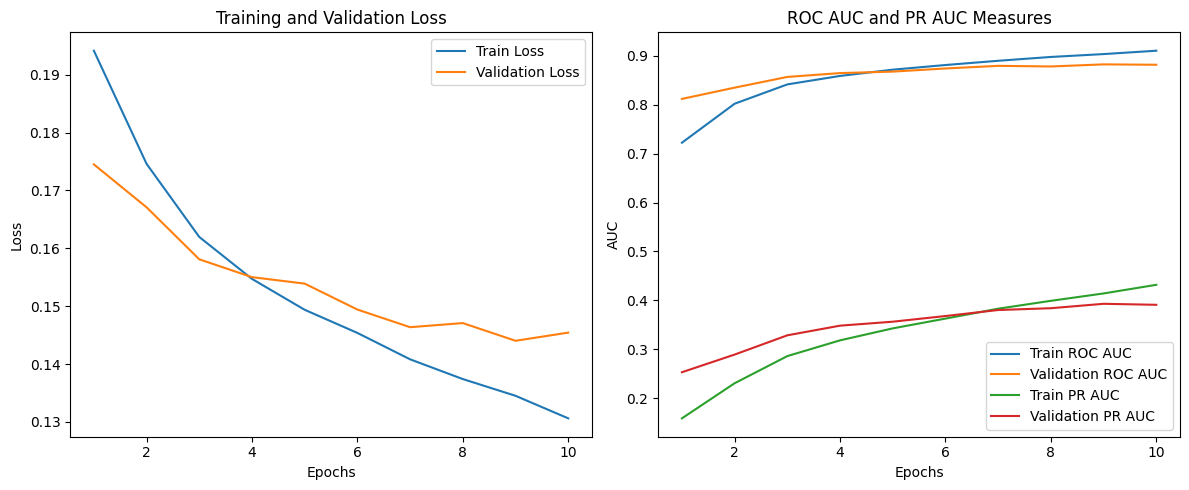

In [19]:
import matplotlib.pyplot as plt

# Extract the metrics from the history dictionary
train_loss = trainer.history['train_loss']
val_loss = trainer.history['val_loss']
train_roc_auc = trainer.history['train_roc_auc']
val_roc_auc = trainer.history['val_roc_auc']
train_pr_auc = trainer.history['train_pr_auc']
val_pr_auc = trainer.history['val_pr_auc']

# Create subplots for loss and AUC measures
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation loss
ax1.plot(range(1, len(train_loss) + 1), train_loss, label='Train Loss')
ax1.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

# Plot ROC AUC and PR AUC measures
ax2.plot(range(1, len(train_roc_auc) + 1), train_roc_auc, label='Train ROC AUC')
ax2.plot(range(1, len(val_roc_auc) + 1), val_roc_auc, label='Validation ROC AUC')
ax2.plot(range(1, len(train_pr_auc) + 1), train_pr_auc, label='Train PR AUC')
ax2.plot(range(1, len(val_pr_auc) + 1), val_pr_auc, label='Validation PR AUC')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('AUC')
ax2.set_title('ROC AUC and PR AUC Measures')
ax2.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [21]:
avg_loss, accuracy, roc_auc, pr_auc = trainer.evaluate(test_dataloader)

In [33]:
pr_auc

0.39073961145775704

In [32]:
roc_auc

0.8818855263942124

### Load the model when the 

In [34]:
# train model
trainer_test = Trainer(model, train_dataloader, val_dataloader, criterion, optimizer, device)

In [37]:
trainer_test.load_model('../models/waveform_cnn.pth')